# Water Quality Analysis

# Introduction
Build a multi-layer feed-forward neural network to predict from a set of input features whether the phytoplankton level detected is above the threshold speciﬁed.

In [1]:
# read the following libraries for Neural Network modeling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# library for deep learning model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from ann_visualizer.visualize import ann_viz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# library for data augmentation
from collections import Counter
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
import imblearn
from imblearn.over_sampling import SMOTE

# library for plotting correlation
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()


## Read Data

In [2]:
# load the data
df = pd.read_excel('results-2021-cefas-website.xlsx', header=1, sheet_name = 'Phytoplankton results')

In [3]:
# extract the following columns
c = ['Sample number', 'Alexandrium spp. \ncells L-1\n(PSP)', 'Dinophysiaceae \ncells L-1\n(DSP)',  'Prorocentrum lima \ncells L-1\n(DSP)', 'Pseudo-nitzschia spp. \ncells L-1\n(ASP) ' ]
df = df[:828]
df = df[c]

# rename the columns to be readable
df.columns = ['sample_number','alexandrium', 'dinophy', 'prorocentrum', 'pseudo']

# show the first five
df.head(5)

,sample_number,alexandrium,dinophy,prorocentrum,pseudo
0,1/21,ND,ND,ND,ND
1,2/21,ND,ND,ND,ND
2,3/21,ND,ND,ND,400
3,4/21,ND,ND,ND,ND
4,5/21,ND,ND,ND,ND


In [4]:
# produce the data shape 
rows, columns = df.shape
print(f'The number of rows and columns are {rows} and {columns} respectively')

The number of rows and columns are 828 and 5 respectively


In [5]:
# understand the dataset
df.describe()

,sample_number,alexandrium,dinophy,prorocentrum,pseudo
count,828,828,827,827,827
unique,828,13,25,9,206
top,490/21,ND,ND,ND,ND
freq,1,770,700,792,379


# Data Cleaning

In [6]:
# produce the unique values within the alexandrium columns
df.alexandrium.unique()

array(['ND', 'Unable to analyse, too much sediment', 200, 40, 100, 120,
       80, 320, 400, 500, 'NOT TESTED, SUBMITTED IN ERROR', 160, 240],
      dtype=object)

In [7]:
# produce the unique values within the dinophysiaceae columns
df.dinophy.unique()

array(['ND', 'Unable to analyse, too much sediment', 40, 80, 160, 520,
       240, 320, 200, 280, 400, 120, 800, 1360, 720, 640, 680, nan, 1880,
       100, 2960, 1400, 480, 1320, 1000, 760], dtype=object)

In [8]:
# produce the unique values within the prorocentrum columns
df.prorocentrum.unique()

array(['ND', 'Unable to analyse, too much sediment', 100, 40, 200, 120,
       nan, 400, 18520, 17480], dtype=object)

In [9]:
# produce the unique values within the pseudo-nitzschia columns
df.pseudo.unique()

array(['ND', 400, 'Unable to analyse, too much sediment', 200, 800, 600,
       80, 1000, 160, 320, 560, 3600, 1160, 2400, 2700, 12720, 1400, 240,
       640, 880, 960, 3200, 1080, 840, 3800, 2360, 4600, 8760, 3480, 120,
       1920, 1760, 280, 1960, 5600, 4280, 3960, 8100, 10300, 3000, 1480,
       720, 2080, 8600, 185500, 60900, 1800, 6280, 2900, 1900, 2000, 1840,
       2280, 7080, 13080, 17400, 13720, 11300, 8300, 2100, 360, 1200,
       4800, 1120, 66400, 152900, 71400, 13520, 42120, 38520, 1640, 1300,
       6440, 3280, 13680, 252000, 18400, 1600, 8000, 1360, 5800, 760,
       7560, 27800, 289400, 68760, 15280, 23000, 34600, 60000, 43000,
       6640, 8800, 16600, 17120, 6320, 48400, 1100, 162000, 24600, 4200,
       8920, 16320, 1680, 520, 220, 2840, 1240, 3080, 15100, 52700, 4700,
       11560, 45440, 3520, 52200, 19240, 11000, 13600, 19360, 40, 2720,
       7200, 1560, 24900, 58600, 753000, 6880, 2200, 118000, 5480, 480,
       7120, 9360, 12760, 11320, 6480, 109000, 9000, 120

In [10]:
# create a function to help with cleaning
def clean_data(df):
    df.alexandrium = df.alexandrium.replace('ND', 0)
    df.dinophy = df.dinophy.replace('ND', 0)
    df.prorocentrum = df.prorocentrum.replace('ND', 0)
    df.pseudo = df.pseudo.replace('ND', 0)
    
    df.alexandrium = pd.to_numeric(df.alexandrium, errors = 'coerce')
    df.dinophy = pd.to_numeric(df.dinophy, errors = 'coerce')
    df.prorocentrum = pd.to_numeric(df.prorocentrum, errors = 'coerce')
    df.pseudo = pd.to_numeric(df.pseudo, errors = 'coerce')

In [11]:
clean_data(df)

In [12]:
# check for missing values
df.isnull().sum()

sample_number     0
alexandrium      19
dinophy          19
prorocentrum     19
pseudo           19
dtype: int64

In [13]:
# impute the missing value with -1
df.fillna(-1, inplace=True)

In [14]:
# confirm that there are no missing values
df.isnull().sum()

sample_number    0
alexandrium      0
dinophy          0
prorocentrum     0
pseudo           0
dtype: int64

# Data Labelling

In [15]:
# create a function that labels the data based on the threshold created
thresholds = {"alexandrium" : 40, "dinophy" : 100, "prorocentrum" : 100, "pseudo" : 150000}

def check_thresholds(df):
    t = []
    for i,j in enumerate(df["sample_number"]):
        
        alexandrium = df.iloc[i]["alexandrium"]
        pseudo_nitzschia = df.iloc[i]["pseudo"]
        dinophysiaceae = df.iloc[i]["dinophy"]
        prorocentrum = df.iloc[i]["prorocentrum"]
        
        threshold_reached = 0
        if pseudo_nitzschia >= thresholds["pseudo"]:
            threshold_reached = 1
        elif dinophysiaceae >= thresholds["dinophy"]:
            threshold_reached = 1
        elif prorocentrum >= thresholds["prorocentrum"]:
            threshold_reached = 1
        elif alexandrium >= thresholds["alexandrium"]:
            threshold_reached = 1
    
        t.append(threshold_reached)
        
    return t

In [16]:
# add the new column to the dataframe
thresholds_reached = check_thresholds(df)
df['thresholds_reached'] = thresholds_reached 

In [17]:
# create a csv file 
pd.DataFrame.to_csv(df, 'thresholds_cleaned.csv', sep=',', index=False)

In [18]:
# extract the input variables and output variable
x = pd.read_csv('thresholds_cleaned.csv', usecols=["pseudo", "dinophy", "prorocentrum", "alexandrium"], na_values = ['no info', '.'])

y = pd.read_csv('thresholds_cleaned.csv', usecols=["thresholds_reached"])

# Data Visualization
Visualize the variables by studying their relationship amongst themselves.

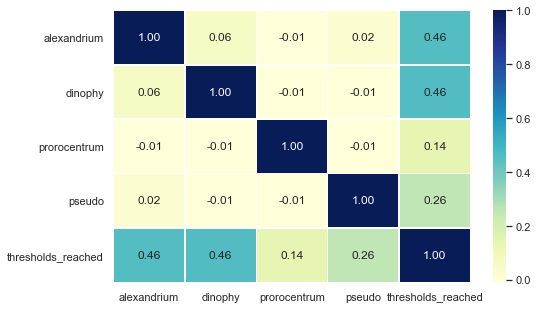

In [19]:
# show the relationship between the variables
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(corrMatrix, annot=True, linewidths=0.5, fmt= ".2f", cmap="YlGnBu")


<AxesSubplot:title={'center':'Relationship of variables to the threshold reached'}>

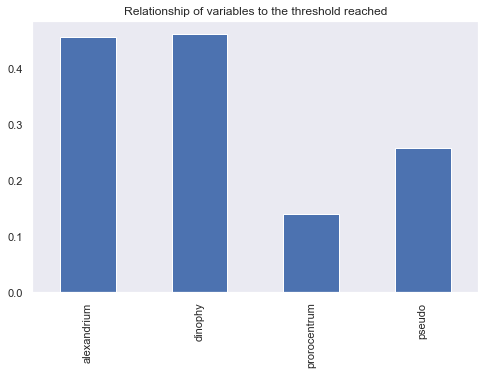

In [20]:
df.drop('thresholds_reached', axis=1).corrwith(df.thresholds_reached).plot(kind='bar', 
                                    grid = False, figsize=(8,5),
                                    title = 'Relationship of variables to the threshold reached')

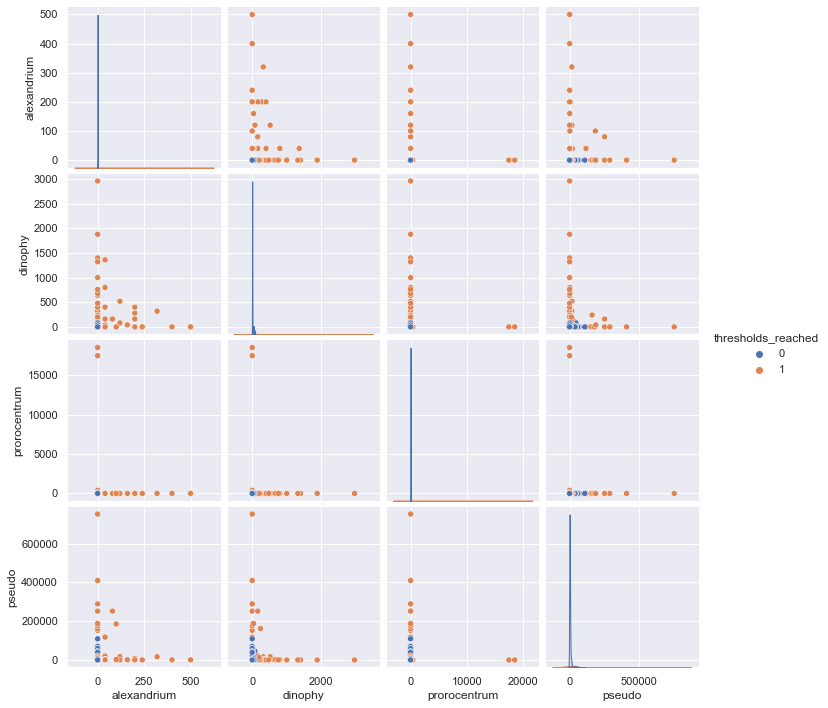

In [21]:
# show the relationship to each condition on the threshold reached
sns.pairplot(df, vars=('alexandrium', 'dinophy', 'prorocentrum', 'pseudo'), hue='thresholds_reached')

In [22]:
# count how many reached and exceed the threshold created 
print(f'The number of Pseudo-nitzschia spp. reaching the threshold is {len(df[df.pseudo >= thresholds["pseudo"]])}')
print(f'The number of Alexandrium spp reaching the threshold is {len(df[df.alexandrium >= thresholds["alexandrium"]])}')
print(f'The number of Prorocentrum lima reaching the threshold is {len(df[df.prorocentrum >= thresholds["prorocentrum"]])}')
print(f'The number of Dinophysiaceae reaching the threshold is {len(df[df.dinophy >= thresholds["dinophy"]])}')

print("================================================================")
print("________________________________________________________________")
# count how many reached and exceed the threshold created 
print(f'The maximum level under Pseudo-nitzschia spp. is {df.pseudo.max()}')
print(f'The maximum level under Alexandrium spp is {df.alexandrium.max()}')
print(f'The maximum level under Prorocentrum lima is {df.prorocentrum.max()}')
print(f'The maximum level under Dinophysiaceae is {df.dinophy.max()}')


The number of Pseudo-nitzschia spp. reaching the threshold is 10
The number of Alexandrium spp reaching the threshold is 39
The number of Prorocentrum lima reaching the threshold is 8
The number of Dinophysiaceae reaching the threshold is 51
________________________________________________________________
The maximum level under Pseudo-nitzschia spp. is 753000.0
The maximum level under Alexandrium spp is 500.0
The maximum level under Prorocentrum lima is 18520.0
The maximum level under Dinophysiaceae is 2960.0


# Deep Learning

## Model

In [23]:
# split the data into 80% training and 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=42)

In [24]:
# create an neural network model
model = Sequential()
model.add(Dense(units=80, kernel_initializer='uniform', activation='relu', input_shape=(4,)))
model.add(Dropout(0.5))
model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

epochs = 20

history = model.fit(x_train, y_train,batch_size=16,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                400       
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 5,321
Trainable params: 5,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 [==============================] - 1s

## Model refinement
Perform model optimizations by carrying out hyperparameter tuning.

In [25]:
# using GridSearch to tune the model
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=42)

# define the grid search parameters
neurons = [10,20,30,40]
rate = [0.2,0.3,0.4,0.5]
activation = ['relu', 'tanh', 'softmax', 'sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
batch_size = [20, 40, 60, 80]
epochs = [20, 40, 60, 80]

param_grid = dict(activation = activation, optimizer=optimizer, batch_size=batch_size, epochs=epochs, 
neurons = neurons, rate = rate)

# function to create model, required for KerasClassifier
def net_model(optimizer='adam', activation=activation, neurons=20, rate = 0.0):
    model = Sequential()
    model.add(Dense(units=neurons, kernel_initializer='uniform', activation=activation, input_shape=(4,)))
    model.add(Dropout(rate))
    model.add(Dense(units=neurons, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(rate))
    model.add(Dense(units=neurons, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(rate))
    model.add(Dense(units=neurons, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(rate))
    model.add(Dense(1, activation='sigmoid'))
	
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# create model
model = KerasClassifier(build_fn=net_model, verbose = 0)

es = EarlyStopping(monitor='accuracy', mode = 'max', verbose = 0, patience = 20)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, validation_data=(x_test, y_test))

# summarize results
print("The best produces an accuracy of: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-25-ac2a16f2e3a2>:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=net_model, verbose = 0)


The best produces an accuracy of: 0.981880 using {'activation': 'relu', 'batch_size': 60, 'epochs': 60, 'neurons': 10, 'optimizer': 'RMSprop', 'rate': 0.2}
0.895763 (0.003898) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'SGD', 'rate': 0.2}
0.891252 (0.009637) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'SGD', 'rate': 0.3}
0.886720 (0.007197) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'SGD', 'rate': 0.4}
0.883697 (0.007531) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'SGD', 'rate': 0.5}
0.935088 (0.031372) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'RMSprop', 'rate': 0.2}
0.888228 (0.010556) with: {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'neurons': 10, 'optimizer': 'RMSprop', 'rate': 0.3}
0.883697 (0.007531) with: {'activation': 'relu', 'batch_size':

## Best Model
This uses the best paramater generated from the hyperparameter tuning carried out in the last section.

In [53]:
# best parameter
grid_result.best_params_

{'activation': 'relu',
 'batch_size': 60,
 'epochs': 60,
 'neurons': 10,
 'optimizer': 'RMSprop',
 'rate': 0.2}

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=42)

model = Sequential()
model.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation'], input_shape=(4,)))
model.add(Dropout(grid_result.best_params_['rate']))
model.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model.add(Dropout(grid_result.best_params_['rate']))
model.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model.add(Dropout(grid_result.best_params_['rate']))
model.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model.add(Dropout(grid_result.best_params_['rate']))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',optimizer=grid_result.best_params_['optimizer'],metrics=['accuracy'])

epochs = grid_result.best_params_['epochs']

history = model.fit(x_train, y_train,batch_size=grid_result.best_params_['batch_size'],epochs=epochs,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 10)                50        
                                                                 
 dropout_22 (Dropout)        (None, 10)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 dropout_23 (Dropout)        (None, 10)                0         
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 dropout_24 (Dropout)        (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 10)               

## Visualization from the model
Produce the neutral network diagram. Also show the test and evaluation image of the accuracy and loss per the epochs.

In [27]:
# showing the neutral network
try:
    ann_viz(model, view = True, title="The neural network framework", filename="v")
except AttributeError as error:
    print(error)

module 'graphviz.backend' has no attribute 'ENCODING'


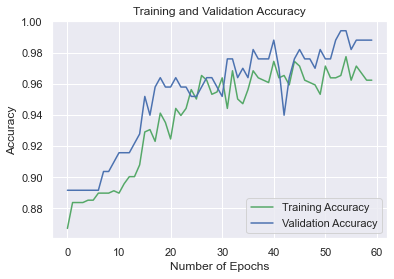

In [42]:
# this plots the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, 'g', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig("water_quality_1.pdf", dpi=100)
plt.show()

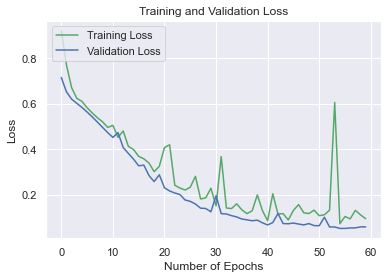

In [43]:
# this plots the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, 'g', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper left')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig("water_quality_2.pdf", dpi=100)
plt.show()

In [44]:
# make a prediction
predictions = (model.predict(x_test) > 0.5).astype(int)

y_test['pred'] = predictions
y_test.head(20)

,thresholds_reached,pred
608,0,0
457,0,0
290,0,0
558,0,0
168,0,0
684,0,0
814,0,0
86,0,0
260,0,0
680,0,0


## Data Augmentation
Check if the dataset used is unbalanced or balance.

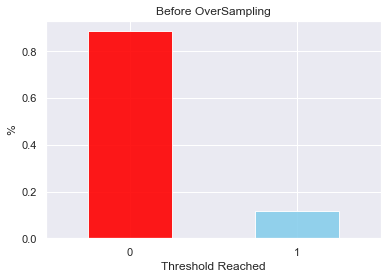

In [45]:
# visualize the data based on the threshold reached
df['thresholds_reached'].value_counts(normalize = True).plot(kind = 'bar', color =['red', 'skyblue'], alpha = 0.9, rot =0)
plt.title('Before OverSampling')
plt.xlabel('Threshold Reached')
plt.ylabel('%')
plt.show()

In [46]:
# number of threshold reached
print("Before OverSampling, counts of label '1': {}".format(sum(y["thresholds_reached"] == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y["thresholds_reached"] == 0)))

Before OverSampling, counts of label '1': 95
Before OverSampling, counts of label '0': 733 



In [47]:
# this resamples the dataset 
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(x, y["thresholds_reached"].ravel())

In [48]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, counts of label '1': 733
After OverSampling, counts of label '0': 733


In [51]:
# train the oversampling data using the best model
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train_res, y_train_res, train_size=0.80, random_state=42)

model1 = Sequential()
model1.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation'], input_shape=(4,)))
model1.add(Dropout(grid_result.best_params_['rate']))
model1.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model1.add(Dropout(grid_result.best_params_['rate']))
model1.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model1.add(Dropout(grid_result.best_params_['rate']))
model1.add(Dense(units=grid_result.best_params_['neurons'], kernel_initializer='uniform', activation=grid_result.best_params_['activation']))
model1.add(Dropout(grid_result.best_params_['rate']))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

model1.compile(loss='binary_crossentropy',optimizer=grid_result.best_params_['optimizer'],metrics=['accuracy'])

epochs = grid_result.best_params_['epochs']

history1 = model1.fit(x_train1, y_train1,batch_size=grid_result.best_params_['batch_size'],epochs=epochs,verbose=1,validation_data=(x_test1, y_test1))
score1 = model1.evaluate(x_test1, y_test1, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

print("\n%s: %.2f%%" % (model1.metrics_names[1], score1[1]*100))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 10)                50        
                                                                 
 dropout_34 (Dropout)        (None, 10)                0         
                                                                 
 dense_44 (Dense)            (None, 10)                110       
                                                                 
 dropout_35 (Dropout)        (None, 10)                0         
                                                                 
 dense_45 (Dense)            (None, 10)                110       
                                                                 
 dropout_36 (Dropout)        (None, 10)                0         
                                                                 
 dense_46 (Dense)            (None, 10)               

# Test and Evaluation

In [52]:
# create a confusion matrix 
actual = y_test['thresholds_reached']
predicted = y_test['pred']

conf_matrix = pd.crosstab(actual, predicted,
                            rownames = ['Actual'],
                            colnames = ['Predicted'],
                            margins = True)

#classification report
class_report = classification_report(actual, predicted)

# print the confusion and classification report
print("Test Result: \n==========================================")
print("_________________________________________________________")
print(f"Confusion Matrix: \n {conf_matrix}\n")
print("_________________________________________________________")
print(f"Classification Report: \n {class_report}\n")

Test Result: 
_________________________________________________________
Confusion Matrix: 
 Predicted    0   1  All
Actual                 
0          148   0  148
1            2  16   18
All        150  16  166

_________________________________________________________
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       148
           1       1.00      0.89      0.94        18

    accuracy                           0.99       166
   macro avg       0.99      0.94      0.97       166
weighted avg       0.99      0.99      0.99       166


